In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2026-01-21 19:25:09.431003: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-21 19:25:09.667986: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-21 19:25:10.534747: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-21 19:25:10.534807: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-21 19:25:10.541878: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

## Load dataset

In [123]:
path = "../pitch/GPS_cmd_16k_renamed_pyin_avg_by_word_user.csv"
df = pd.read_csv(path)
df

,filepaths,users,genders,words,f0
0,/home/jovyan/work/OneDrive/Documentos/Doutorad...,F001,F,academia,207
1,/home/jovyan/work/OneDrive/Documentos/Doutorad...,F001,F,academia,207
2,/home/jovyan/work/OneDrive/Documentos/Doutorad...,F001,F,academia,207
3,/home/jovyan/work/OneDrive/Documentos/Doutorad...,F001,F,academia,207
4,/home/jovyan/work/OneDrive/Documentos/Doutorad...,F001,F,academia,207
...,...,...,...,...,...
3995,/home/jovyan/work/OneDrive/Documentos/Doutorad...,M020,M,trabalho,102
3996,/home/jovyan/work/OneDrive/Documentos/Doutorad...,M020,M,trabalho,102
3997,/home/jovyan/work/OneDrive/Documentos/Doutorad...,M020,M,trabalho,102
3998,/home/jovyan/work/OneDrive/Documentos/Doutorad...,M020,M,trabalho,102


users f/m = 20 -  train: 14, val: 2, test: 4

Test: F017 F018 F019 F020 M017 M018 M019 M020

Val: F015 F016 M015 M016

Train: restante

In [124]:
df_test = df[(df["users"] == "F017") | (df["users"] == "F018") | (df["users"] == "F019") | (df["users"] == "F020") \
| (df["users"] == "M017") | (df["users"] == "M018") | (df["users"] == "M019") | (df["users"] == "M020")].reset_index(drop=True)

In [125]:
df_val = df[(df["users"] == "F015") | (df["users"] == "F016") | (df["users"] == "M015") | (df["users"] == "M016")].reset_index(drop=True)

In [126]:
df_diff = df.merge(df_test, how='outer', indicator=True).loc[lambda x : x['_merge'] == 'left_only'].drop(columns=['_merge'])

In [127]:
df_train = df_diff.merge(df_val, how='outer', indicator=True).loc[lambda x : x['_merge'] == 'left_only'].drop(columns=['_merge'])

In [56]:
"Train: ", len(df_train), "Val: ", len(df_val), "Test: ", len(df_test)

('Train: ', 2800, 'Val: ', 400, 'Test: ', 800)

In [128]:
def get_files(df):
    files = list(df["filepaths"])
    labels = list(df["words"])
    return files, labels

In [129]:
train_files, train_labels = get_files(df_train)
val_files, val_labels = get_files(df_val)
test_files, test_labels = get_files(df_test)

## Read Dataset

In [63]:
path_1 = df_test["filepaths"][0]

In [64]:
test_file = tf.io.read_file(path_1)
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([16106, 1])

In [69]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

Defina outra função auxiliar— get_waveform_and_label —que junte tudo:

- A entrada é o nome do arquivo de áudio WAV.
- .
A saída é uma tupla contendo os tensores de áudio e rótulo prontos para aprendizado supervisionado.

In [66]:
def get_waveform_and_label(file_path, label):
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

#### Crie o conjunto de treinamento para extrair os pares de rótulo de áudio:

Crie um tf.data.Dataset com Dataset.from_tensor_slices e Dataset.map , usando get_waveform_and_label definido anteriormente.
Você construirá os conjuntos de validação e teste usando um procedimento semelhante posteriormente.

In [70]:
AUTOTUNE = tf.data.AUTOTUNE

val_ds = tf.data.Dataset.from_tensor_slices((val_files, val_labels))

val_waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

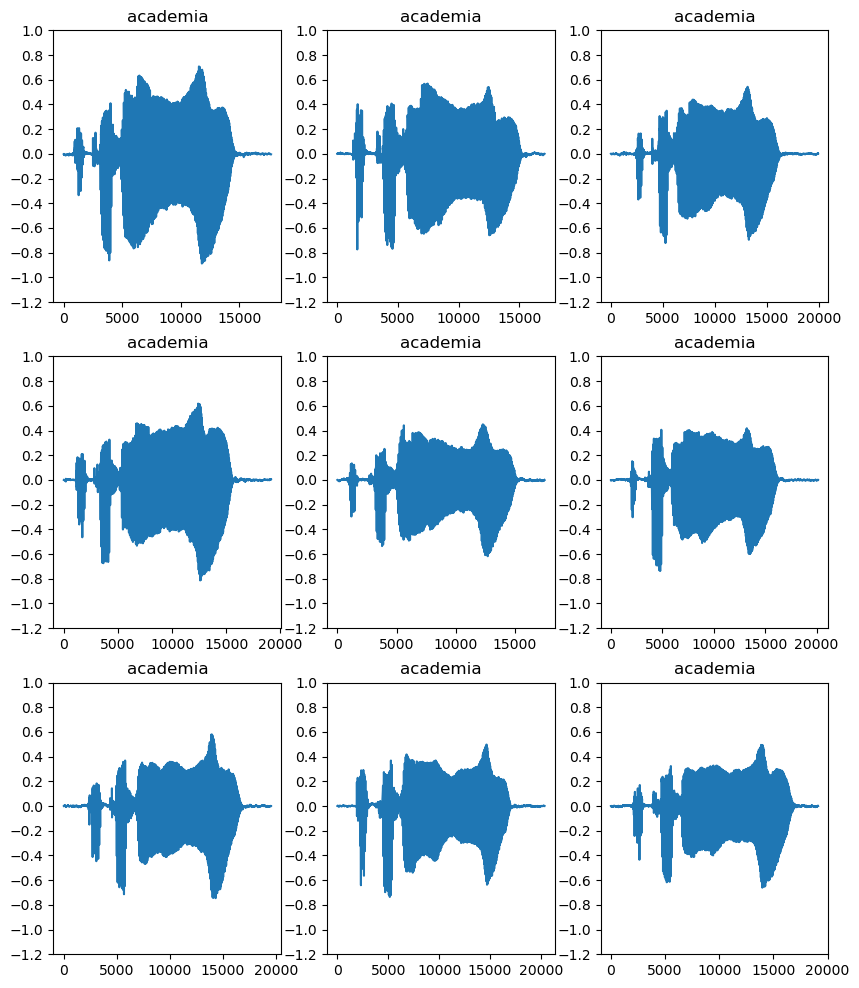

In [71]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(val_waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Converter formas de onda em espectrogramas

In [72]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [73]:
for waveform, label in val_waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000, normalize=False))

Label: academia
Waveform shape: (17705,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [74]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

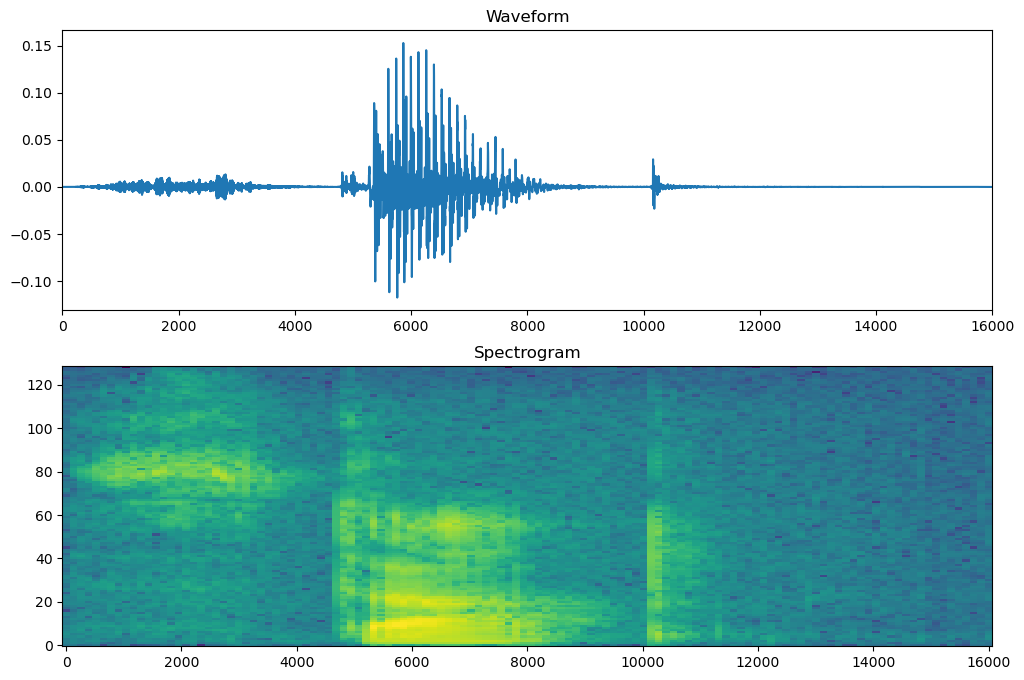

In [19]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Mapeie get_spectrogram_and_label_id entre os elementos do conjunto de dados com Dataset.map :

In [77]:
LABELS = list(df["words"].unique())
LABELS

['academia',
 'aeroporto',
 'casa',
 'cinema',
 'escola',
 'faculdade',
 'farmacia',
 'hospital',
 'mercado',
 'trabalho']

In [78]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == LABELS)
  return spectrogram, label_id

In [79]:
val_spectrogram_ds = val_waveform_ds.map( map_func=get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

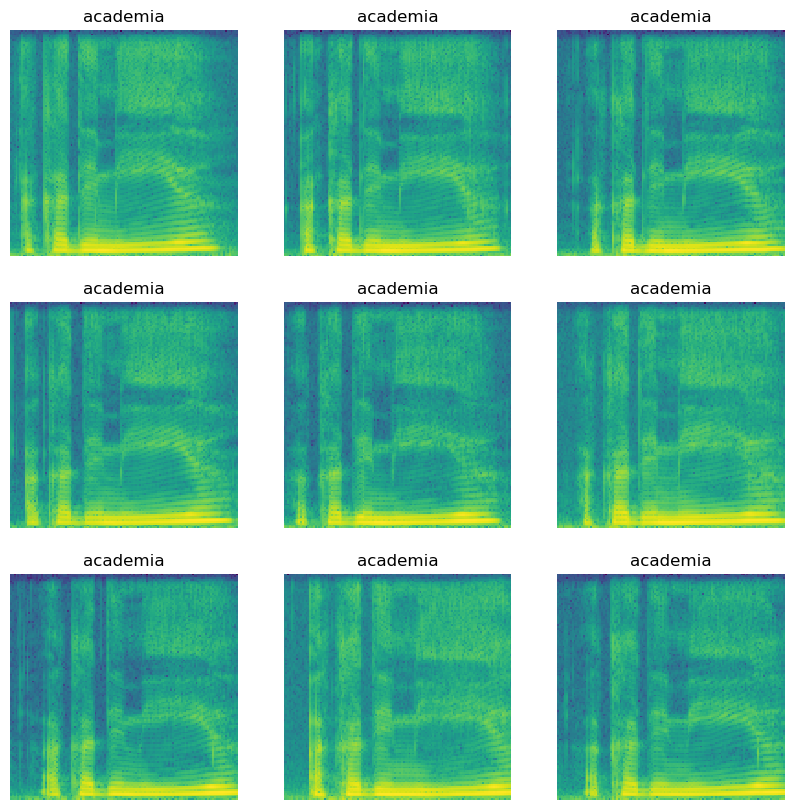

In [82]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(val_spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(LABELS[label_id.numpy()])
  ax.axis('off')

plt.show()

## Construir e treinar o modelo

In [130]:
def preprocess_dataset(files, labels):
  files_ds = tf.data.Dataset.from_tensor_slices((files, labels))
  output_ds = files_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
  return output_ds

In [131]:
train_ds = preprocess_dataset(train_files, train_labels)
val_ds = preprocess_dataset(val_files, val_labels)
test_ds = preprocess_dataset(test_files, test_labels)

In [86]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Adicione as operações Dataset.cache e Dataset.prefetch para reduzir a latência de leitura durante o treinamento do modelo:

In [87]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

Para o modelo, você usará uma rede neural convolucional simples (CNN), pois transformou os arquivos de áudio em imagens de espectrograma.

Seu modelo tf.keras.Sequential usará as seguintes camadas de pré-processamento Keras:

- tf.keras.layers.Resizing : para reduzir a amostra da entrada para permitir que o modelo treine mais rápido.
- tf.keras.layers.Normalization : para normalizar cada pixel da imagem com base em sua média e desvio padrão.

Para a camada de Normalization , seu método de adapt precisaria primeiro ser chamado nos dados de treinamento para calcular estatísticas agregadas (ou seja, a média e o desvio padrão).

In [91]:
for spectrogram, _ in val_spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(LABELS)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=val_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

In [94]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [95]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
44/44 [==============================] - 3s 51ms/step - loss: 1.9240 - accuracy: 0.2689 - val_loss: 2.0076 - val_accuracy: 0.2700
Epoch 2/10
44/44 [==============================] - 2s 48ms/step - loss: 1.7268 - accuracy: 0.3329 - val_loss: 1.5085 - val_accuracy: 0.4825
Epoch 3/10
44/44 [==============================] - 2s 44ms/step - loss: 1.2747 - accuracy: 0.5736 - val_loss: 1.2228 - val_accuracy: 0.6175
Epoch 4/10
44/44 [==============================] - 2s 44ms/step - loss: 0.9747 - accuracy: 0.6700 - val_loss: 1.1372 - val_accuracy: 0.6725
Epoch 5/10
44/44 [==============================] - 2s 48ms/step - loss: 0.6492 - accuracy: 0.8014 - val_loss: 0.7972 - val_accuracy: 0.7975
Epoch 6/10
44/44 [==============================] - 2s 46ms/step - loss: 0.4357 - accuracy: 0.8661 - val_loss: 0.7590 - val_accuracy: 0.7975
Epoch 7/10
44/44 [==============================] - 2s 47ms/step - loss: 0.2683 - accuracy: 0.9246 - val_loss: 0.6391 - val_accuracy: 0.8250
Epoch 8/10
44

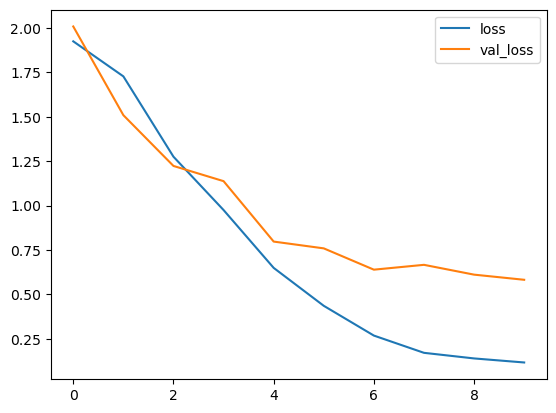

In [96]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [97]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [98]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

25/25 [==============================] - 0s 10ms/step
Test set accuracy: 97%


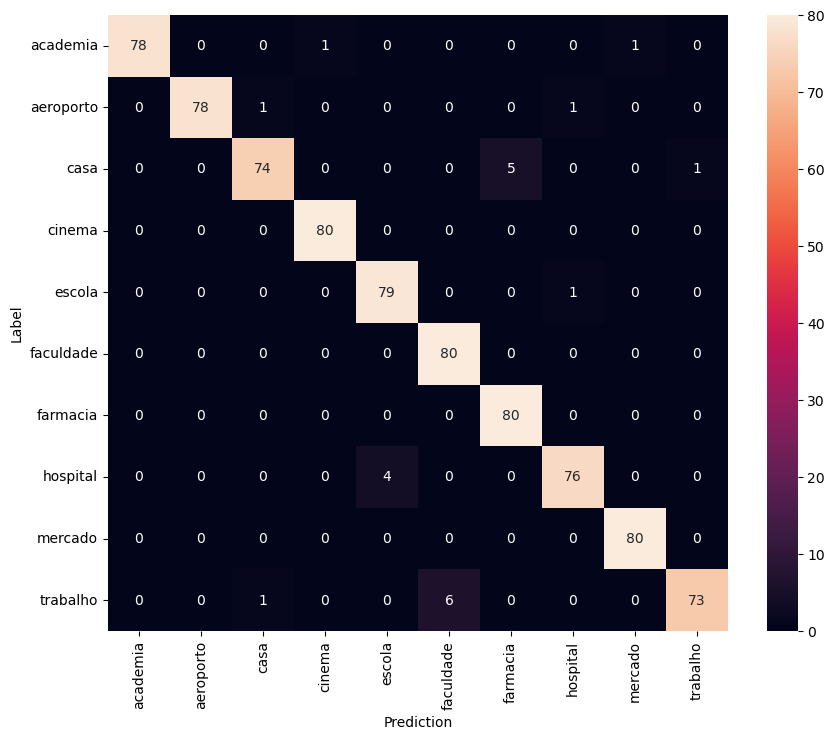

In [100]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=LABELS,
            yticklabels=LABELS,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Executar inferência em um arquivo de áudio

In [132]:
path_test = df_test["filepaths"][799]
word_test = [9]
path_test, word_test

('/home/jovyan/work/OneDrive/Documentos/Doutorado/dataset/GPS_cmd_16k_renamed/trabalho_M020_010.wav',
 [9])

In [135]:
sample_ds = preprocess_dataset(str(path_test), word_test)

ValueError: Unbatching a tensor is only supported for rank >= 1

In [ ]:
for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(LABELS, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{LABELS[label[0]]}"')
  plt.show()

Reference: 
- https://www.tensorflow.org/tutorials/audio/simple_audio?hl=pt-br
- https://medium.com/@oluyaled/audio-classification-using-deep-learning-and-tensorflow-a-step-by-step-guide-5327467ee9ab
- https://www.tensorflow.org/api_docs/python/tf/signal/mfccs_from_log_mel_spectrograms
- https://www.tensorflow.org/api_docs/python/tf/signal/stft